# Creating the dictionary graph from raw csv file

In [50]:
import pandas as pd

path = "routes_master_data.csv"
df = pd.read_csv(path)
for key in df.keys():
    print(key, len(df[key].unique()), "elements", df[key].unique())

Route_ID 1693 elements [14010000668408490 14010000668408521 14010000664752659 ...
 14010000628714328 14010000657906546 14010000573766928]
Route_Name 363 elements ['Vigelsjö' 'Campus Roslagen' 'Scaniarinken' 'Östertälje station'
 'Lina hage' 'Södertälje hamn station' 'Torö' 'Nynäshamns station'
 'Kungsängens station' 'Håtuna kyrka'
 'Jakobsberg - Barkarby handelsplats - Kassavägen'
 'Jakobsberg - Kassavägen - Barkarby handelsplats' 'Grödby' 'Nynäshamns'
 'Liljeholmen' 'Farsta centrum' 'Ropsten' 'Norra Hammarbyhamnen' 'Slussen'
 'Saltarö' 'Skarpnäck' 'Hässelby strand' 'Norra Lagnö' 'Vaxholm'
 'Ljusterö' 'Stockholm' 'Fresta' 'Upplands Väsby station' 'Vidja'
 'Smådalarö' 'Handens station' 'Rotebro station' 'Gustavsberg'
 'Cityterminalen' 'Resarö' 'Björkö' 'Norrtälje' 'Kottla' 'Rånäs' 'Rimbo'
 'Herräng-Hallstavik-Herräng' 'Hallstavik-Herräng-Hallstavik'
 'Jakobsbergs station' 'Kalhälls station' 'Västerhaninge station'
 'Ösmo centrum' 'Centralen' 'Djurgårdsbrunn' 'Stockholm C'
 'Orminge cent

In [ ]:
import math
import pandas as pd
from tqdm import tqdm
import pickle

def time_to_seconds(time_str):
    """
    Converts a 'HH:MM:SS' string into seconds after midnight (integer).
    Returns None if the input is invalid (NaN or None).
    """
    if not time_str or pd.isna(time_str):
        return None
    
    hh, mm, ss = time_str.split(":")
    return int(hh) * 3600 + int(mm) * 60 + int(ss)

def build_traffic_graph(csv_path, stop_scenic_values):
    # Convert stop_scenic_values into a lookup dictionary
    scenic_lookup = {}
    for entry in stop_scenic_values:
        scenic_lookup.update(entry)  # Merge dictionaries

    # Initialize the graph
    graph = {}

    # Read the CSV into a dataframe
    df = pd.read_csv(csv_path)

    # Group by Route, Direction, Journey for consecutive stops
    grouped = df.groupby(["Route_ID", "Direction", "Journey_ID"], dropna=False)
    
    for _, group in tqdm(grouped):
        # Sort by 'Order'
        group_sorted = group.sort_values("Order", ascending=True)
        group_sorted = group_sorted.dropna(subset=["StopPlace Name"]).reset_index(drop=True)

        for i in range(len(group_sorted) - 1):
            from_stop = group_sorted.loc[i, "StopPlace Name"]
            to_stop = group_sorted.loc[i + 1, "StopPlace Name"]

            mode = group_sorted.loc[i, "TransportMode"]
            if pd.isna(mode):
                mode = "unknown"

            dep_time_str = group_sorted.loc[i, "DepartureTime"]
            arr_time_str = group_sorted.loc[i + 1, "ArrivalTime"]
            dep_sec = time_to_seconds(dep_time_str)
            arr_sec = time_to_seconds(arr_time_str)

            # ---------------------------
            # Handle potential day rollover
            # ---------------------------
            travel_time = None
            if dep_sec is not None and arr_sec is not None:
                # If arrival second-of-day is *earlier*, assume next day
                if arr_sec < dep_sec:
                    arr_sec += 24 * 3600  # Add 24 hours in seconds

                travel_time = arr_sec - dep_sec

            # Fetch latitude/longitude
            from_lat = group_sorted.loc[i, "StopPlace Latitude"]
            from_lon = group_sorted.loc[i, "StopPlace Longitude"]
            to_lat = group_sorted.loc[i + 1, "StopPlace Latitude"]
            to_lon = group_sorted.loc[i + 1, "StopPlace Longitude"]

            # Initialize nodes if needed
            if from_stop not in graph:
                graph[from_stop] = {
                    "latitude": from_lat,
                    "longitude": from_lon,
                    "neighbors": {},
                    "scenic_value": scenic_lookup.get(from_stop),
                }
            if to_stop not in graph:
                graph[to_stop] = {
                    "latitude": to_lat,
                    "longitude": to_lon,
                    "neighbors": {},
                    "scenic_value": scenic_lookup.get(to_stop),
                }

            # Initialize or update the edge
            if to_stop not in graph[from_stop]["neighbors"]:
                graph[from_stop]["neighbors"][to_stop] = {
                    "scenic_value": scenic_lookup.get(to_stop),
                }

            # Ensure the mode key is present
            if mode not in graph[from_stop]["neighbors"][to_stop]:
                graph[from_stop]["neighbors"][to_stop][mode] = []

            # Append travel time
            if travel_time is not None:
                graph[from_stop]["neighbors"][to_stop][mode].append(travel_time)

    # Compute average (mean) travel times
    for from_stop, data in graph.items():
        for to_stop, edge_data in data["neighbors"].items():
            for mode, times_list in edge_data.items():
                if isinstance(times_list, list):  # Only process if it is a list
                    edge_data[mode] = sum(times_list) / len(times_list) if times_list else None

    return graph


# -----------------------------
# Example usage
# -----------------------------
with open('stop_scenic_values.json', 'r') as file:
    stop_scenic_values = json.load(file) # [{'Campus Roslagen': 6.5}, {'Stockholmsvägen': 6.5}, ...]

# Path to the CSV
csv_path = "routes_master_data.csv"

# Build the graph
graph = build_traffic_graph(csv_path, stop_scenic_values)
with open('graph_with_scenic_values.pickle', 'wb') as file:
    pickle.dump(graph, file)

# Print a small sample to verify
for i, (src_stop, data) in enumerate(graph.items()):
    if i > 20:  # Limit the output
        break
    print(f"Stop: {src_stop}")
    print(f"  Latitude: {data['latitude']}, Longitude: {data['longitude']}, Scenic Value: {data['scenic_value']}")
    for dst_stop, edge_data in data["neighbors"].items():
        print(f"    -> {dst_stop}: {edge_data}")
    print()

 19%|█▉        | 7390/38281 [00:11<00:47, 653.49it/s] 

In [4]:
system_prompt1 = """Evaluate the scenic and visual characteristics of public transport stops in Stockholm based on their name, season, surroundings, and notable features.

Instructions:

	1.	Describe surroundings and features with balanced, factual observations. Highlight both positives and negatives constructively. Avoid scoring or biased language.
	2.	Focus on:
	•	Neighborhood/District: Characterize the area’s vibe (e.g., residential, historic) and its scenic impact.
	•	Surroundings: Mention landmarks, natural features, urban cleanliness, safety, or neglect.
	•	Accessibility: Highlight features like signage, seating, and wheelchair access.
	•	Cultural/Historical Context: Note any relevant importance.
	•	Public Perception: Assess if it’s popular among locals or tourists or isolated.
	•	Comparative Context: Describe how it stands out or falls short compared to nearby stops.
	3.	Include negative features explicitly (e.g., industrial surroundings, poor lighting, unsafe areas).
	4.	If data is missing (e.g., no landmarks), state it clearly without guessing.
	5.	Ensure descriptions are consistent across transport types and avoid redundancy.
	6.	Consider seasonal variations (e.g., winter vs. summer scenery).
	7.	Evaluate the stop’s appeal to tourists and explorers based on access, surroundings, and proximity to attractions.
"""

system_prompt2 = """You are tasked with evaluating the scenic value of a public transport stop in Stockholm based on a detailed description. Assign a score from 0 to 10 by considering the following:
	1.	Key Elements:
	•	Stop Name: Identify the stop being evaluated.
	•	Season: Assess how the current season impacts scenic appeal.
	•	Surroundings: Note nearby landmarks, nature, or urban features.
	•	Accessibility: Consider ease of access and its influence on appeal.
	2.	Scenic Value Scale:
	•	0: Extremely unattractive (e.g., industrial, poorly maintained areas).
	•	5: Average appeal (functional but unremarkable).
	•	10: Iconic or uniquely scenic (e.g., waterfront views, exceptional design).
	3.	Balancing Factors:
	•	Positive Features: Highlight views, pleasant surroundings, or unique attributes.
	•	Negative Factors: Prioritize significant drawbacks (e.g., poor maintenance) in scoring.
	•	Seasonality: While seasonal changes matter, water stops should generally score higher.
	4.	Consistency: Be realistic and critical when negative elements dominate.

The final score should reflect a balanced, nuanced judgment of the stop’s scenic appeal.

### Example Input Description:
The stop name is 'Arlanda'. It is located in an airport complex, surrounded by large parking lots and commercial buildings. The surroundings
feel quite sterile, with little to no greenery. During the winter, the area is gray and cold, and there is not much to see other than the
airport itself.

### Example Output:
- **Scenic Value**: 3

### Explanation:
- The description highlights an **unattractive environment** with **industrial surroundings**, lack of greenery, and a **sterile** atmosphere.
Winter's grayness and cold further detract from the visual appeal, leading to a low score.

### Example Input Description:
The stop name is 'Solna Centrum'. The station is located in a modern urban setting with a lot of open space, several nearby cafés, and some
green patches. It feels clean and well-maintained, and during the spring, flowers bloom around the area.

### Example Output:
- **Scenic Value**: 7

### Explanation:
- The description mentions **modern urban features** with **open space**, **cafés**, and **green patches**. The **seasonal appeal** of spring
adds to the overall scenic experience, but the setting isn't particularly striking or unique. Still, it is **clean, well-maintained**, and has
some pleasant features, earning a mid-to-high score.
"""

In [6]:
import time

class RateLimiter:
    def __init__(self, max_tokens_per_minute, max_calls_per_minute):
        self.max_tokens_per_minute = max_tokens_per_minute
        self.max_calls_per_minute = max_calls_per_minute
        
        # Tracking tokens and calls
        self.tokens_generated = 0
        self.calls_made = 0
        
        # Start times for the token and call tracking
        self.start_time_tokens = time.perf_counter()
        self.start_time_calls = time.perf_counter()
        self.time_window = 60  # seconds in a minute

    def _check_and_reset(self, current_time, start_time, current_count):
        """
        Resets the count and start time if the time window has passed.
        """
        elapsed_time = current_time - start_time
        if elapsed_time > self.time_window:
            return current_time, 0  # Reset start time and count
        return start_time, current_count

    def check_limit(self, tokens_used=0):
        """
        Checks and enforces both token and call rate limits. If necessary, sleeps until
        it's safe to proceed.
        """
        current_time = time.perf_counter()

        # Reset token and call counters if a new time window has started
        self.start_time_tokens, self.tokens_generated = self._check_and_reset(
            current_time, self.start_time_tokens, self.tokens_generated
        )
        self.start_time_calls, self.calls_made = self._check_and_reset(
            current_time, self.start_time_calls, self.calls_made
        )

        # Increment token and call counts
        self.tokens_generated += tokens_used
        self.calls_made += 1

        # Calculate delays for tokens
        token_delay = 0
        allowed_tokens = self.max_tokens_per_minute * (
            (current_time - self.start_time_tokens) / self.time_window
        )
        if self.tokens_generated > allowed_tokens:
            token_delay = (self.tokens_generated - allowed_tokens) / (
                self.max_tokens_per_minute / self.time_window
            )

        # Calculate delays for calls
        call_delay = 0
        allowed_calls = self.max_calls_per_minute * (
            (current_time - self.start_time_calls) / self.time_window
        )
        if self.calls_made > allowed_calls:
            call_delay = (self.calls_made - allowed_calls) / (
                self.max_calls_per_minute / self.time_window
            )

        # Sleep for the maximum required delay
        if token_delay > 0 or call_delay > 0:
            time.sleep(max(token_delay, call_delay))

rate_limiter = RateLimiter(max_tokens_per_minute=4_000_000, max_calls_per_minute=4_000) # for gemini-flash-8b

# A star search

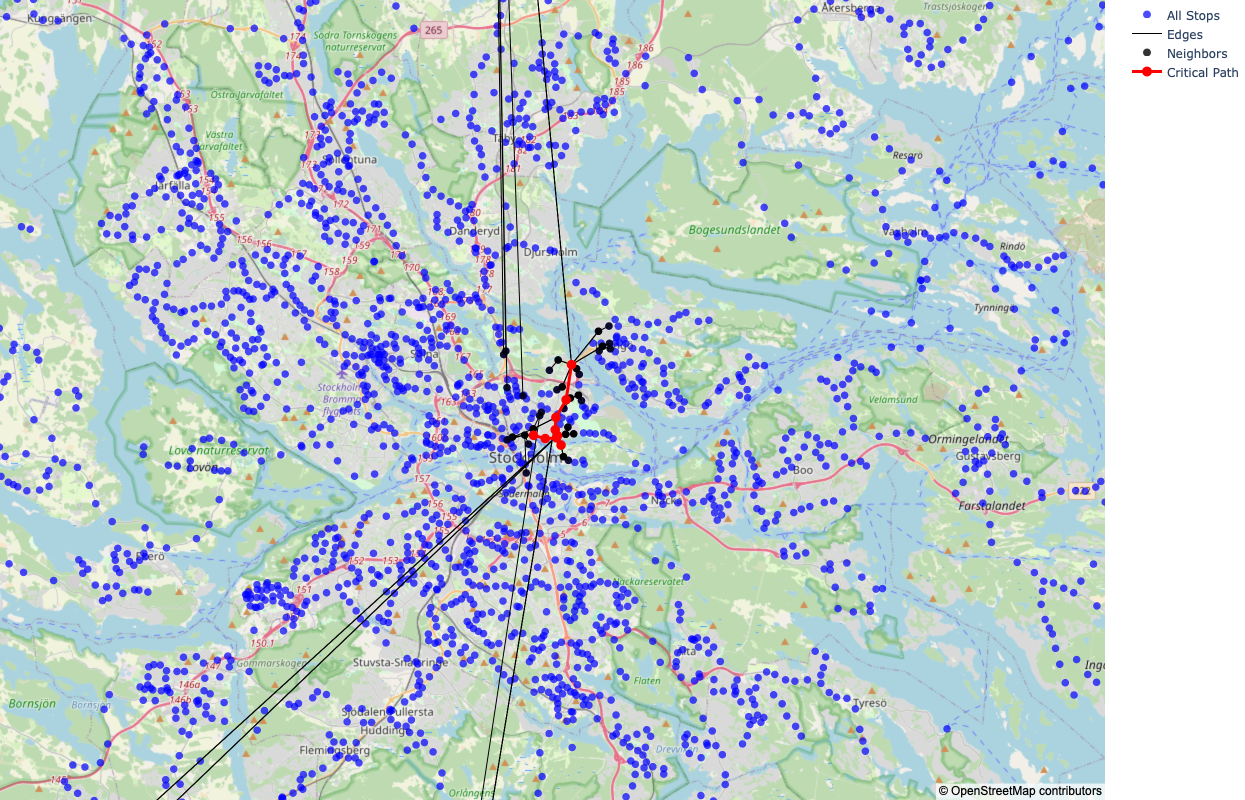

average_scenic_value = 8.35
cumulative_travel_time = 11.65 min


,From,To,Transport Mode,Travel Time (seconds),Current Stop Scenic Value,Next Stop Scenic Value
0,Ropsten,Gärdet,metro,120.00,6.5,7.5
1,Gärdet,Karlaplan,metro,105.00,7.5,6.5
2,Karlaplan,Historiska museet,bus,119.82,6.5,8.5
3,Historiska museet,Strandvägen,bus,53.97,8.5,7.8
4,Strandvägen,Nordiska museet/Vasamuseet,bus,60.39,7.8,8.5
5,Nordiska museet/Vasamuseet,Djurgårdsbron,tram,60.00,8.5,8.5
6,Djurgårdsbron,Styrmansgatan,tram,120.00,8.5,6.5
7,Styrmansgatan,Nybroplan,tram,60.00,6.5,6.5


In [226]:
import heapq
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import pickle

def scenic_cost(scenic_value, C=0.01, lam=1):
    return C * np.exp(-lam * (scenic_value - 10))

def a_star_search(graph, start, goal):
    """
    Perform A* search on the traffic graph to find the shortest path considering scenic values.
    """
    # Scenic factors for transport modes
    transport_mode_scenic_factors = {
        'bus': 1.0,
        'metro': 1.0,
        'water': 1.0,
        'tram': 1.0,
        'rail': 1.0
    }

    # Priority queue for the open list
    open_list = []
    heapq.heappush(open_list, (0, start))
    came_from = {start: None}
    cost_so_far = {start: 0}

    while open_list:
        current_cost, current_stop = heapq.heappop(open_list)

        # Stop if the goal is reached
        if current_stop == goal:
            break

        # Process neighbors
        for neighbor_stop, neighbor_info in graph[current_stop]['neighbors'].items():
            neighbor_scenic_value = neighbor_info.get('scenic_value')

            # Iterate through transport modes and their travel times
            modes = [(m, t) for m, t in neighbor_info.items() if m not in {'scenic_value', 'distance_meters'}]

            for (transport_mode, travel_time) in modes:
                scenic_factor = transport_mode_scenic_factors.get(transport_mode)
                current_scenic_value = graph[current_stop].get('scenic_value')
                avg_scenic_value = (current_scenic_value + neighbor_scenic_value) / 2.0

                # Incorporate scenic factor into the cost
                effective_scenic_value = scenic_factor * avg_scenic_value
                new_cost = cost_so_far[current_stop] + travel_time + scenic_cost(effective_scenic_value)

                # Update if the cost is lower
                if neighbor_stop not in cost_so_far or new_cost < cost_so_far[neighbor_stop]:
                    cost_so_far[neighbor_stop] = new_cost
                    heuristic = 0  # Add heuristic if needed
                    priority = new_cost + heuristic
                    heapq.heappush(open_list, (priority, neighbor_stop))
                    came_from[neighbor_stop] = current_stop

    # Reconstruct the path
    path = []
    current_stop = goal
    while current_stop is not None:
        path.append(current_stop)
        current_stop = came_from.get(current_stop)
    path.reverse()

    return path

# Example Usage
with open('graph_with_scenic_values.pickle', 'rb') as file:
    graph = pickle.load(file)

start_stop = 'Ropsten'
goal_stop = 'Nybroplan'
shortest_path = a_star_search(graph, start_stop, goal_stop)

travel_data = []
for i in range(len(shortest_path) - 1):
    current_stop = shortest_path[i]
    next_stop = shortest_path[i + 1]

    # Grab the neighbor info, e.g. {'bus': 241.0, 'scenic_value': 6.5}
    neighbor_info = graph[current_stop]['neighbors'][next_stop]
    
    # Filter out 'scenic_value' to get (transport_mode, travel_time) pairs
    # For example, mode_time_pairs might be [('bus', 241.0)].
    mode_time_pairs = [
        (mode, travel_time) 
        for mode, travel_time in neighbor_info.items() 
        if mode != 'scenic_value'
    ]

    # If there's exactly one mode, just use that. If there are multiple, pick or loop.
    if len(mode_time_pairs) > 0:
        transport_mode, travel_time = mode_time_pairs[0]
    else:
        # Edge case: no mode found
        transport_mode = None
        travel_time = None

    # Get the scenic values from the graph
    current_scenic_value = graph[current_stop].get('scenic_value')
    next_scenic_value = graph[next_stop].get('scenic_value')

    travel_data.append({
        "From": current_stop,
        "To": next_stop,
        "Transport Mode": transport_mode,
        "Travel Time (seconds)": round(travel_time, 2) if travel_time else None,
        "Current Stop Scenic Value": current_scenic_value,
        "Next Stop Scenic Value": next_scenic_value
    })

travel_df = pd.DataFrame(travel_data)

def visualize_path(graph, path):
    # Extract all stops' data
    all_longitudes = [graph[stop]['longitude'] for stop in graph]
    all_latitudes = [graph[stop]['latitude'] for stop in graph]
    all_stop_names = list(graph.keys())
    all_scenic_values = [graph[stop].get('scenic_value', 0) for stop in graph]

    # Extract edges and neighbors for path vertices and their neighbors
    edges_latitudes = []
    edges_longitudes = []
    edges_hovertext = []
    neighbor_latitudes = []
    neighbor_longitudes = []
    neighbor_hovertext = []

    for stop in path:
        if 'neighbors' in graph[stop]:
            for neighbor, edge_data in graph[stop]['neighbors'].items():
                # Add edges from path to neighbors
                edges_latitudes.extend([graph[stop]['latitude'], graph[neighbor]['latitude'], None])
                edges_longitudes.extend([graph[stop]['longitude'], graph[neighbor]['longitude'], None])
                transportation_mode = edge_data.get('transportation_mode', 'Unknown')
                edges_hovertext.append(
                    f"Edge: {stop} to {neighbor}<br>Transportation Mode: {transportation_mode}"
                )

                # Add neighbors to markers
                neighbor_latitudes.append(graph[neighbor]['latitude'])
                neighbor_longitudes.append(graph[neighbor]['longitude'])
                neighbor_hovertext.append(
                    f"Stop: {neighbor}<br>Scenic Value: {graph[neighbor].get('scenic_value', 0)}"
                )

                # Add edges and markers for neighbors' neighbors
                if 'neighbors' in graph[neighbor]:
                    for second_neighbor, second_edge_data in graph[neighbor]['neighbors'].items():
                        edges_latitudes.extend([graph[neighbor]['latitude'], graph[second_neighbor]['latitude'], None])
                        edges_longitudes.extend([graph[neighbor]['longitude'], graph[second_neighbor]['longitude'], None])
                        second_transportation_mode = second_edge_data.get('transportation_mode', 'Unknown')
                        edges_hovertext.append(
                            f"Edge: {neighbor} to {second_neighbor}<br>Transportation Mode: {second_transportation_mode}"
                        )
                        neighbor_latitudes.append(graph[second_neighbor]['latitude'])
                        neighbor_longitudes.append(graph[second_neighbor]['longitude'])
                        neighbor_hovertext.append(
                            f"Stop: {second_neighbor}<br>Scenic Value: {graph[second_neighbor].get('scenic_value', 0)}"
                        )

    # Extract the longitude, latitude, and scenic values of stops in the critical path
    path_longitudes = [graph[stop]['longitude'] for stop in path]
    path_latitudes = [graph[stop]['latitude'] for stop in path]
    path_scenic_values = [graph[stop].get('scenic_value') for stop in path]
    path_stop_names = path

    # Calculate the average of the start and end stop coordinates for centering the map
    start_longitude = graph[path[0]]['longitude']
    start_latitude = graph[path[0]]['latitude']
    end_longitude = graph[path[-1]]['longitude']
    end_latitude = graph[path[-1]]['latitude']
    avg_longitude = (start_longitude + end_longitude) / 2
    avg_latitude = (start_latitude + end_latitude) / 2

    # Create a Plotly figure
    fig = go.Figure()

    # Add all stops as markers
    fig.add_trace(go.Scattermapbox(
        lat=all_latitudes,
        lon=all_longitudes,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=8,
            color='blue',  # Color for all stops
            opacity=0.7
        ),
        hoverinfo='text',
        hovertext=[f'Stop: {stop_name}<br>Scenic Value: {scenic_value}' 
                   for stop_name, scenic_value in zip(all_stop_names, all_scenic_values)],
        name='All Stops'
    ))

    # Add edges between path vertices, their neighbors, and neighbors' neighbors
    fig.add_trace(go.Scattermapbox(
        lat=edges_latitudes,
        lon=edges_longitudes,
        mode='lines',
        line=go.scattermapbox.Line(
            color='black',
            width=1
        ),
        hoverinfo='text',
        hovertext=edges_hovertext,
        name='Edges'
    ))

    # Add neighbors and their neighbors as black markers
    fig.add_trace(go.Scattermapbox(
        lat=neighbor_latitudes,
        lon=neighbor_longitudes,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=8,
            color='black',  # Color for neighbors
            opacity=0.8
        ),
        hoverinfo='text',
        hovertext=neighbor_hovertext,
        name='Neighbors'
    ))

    # Add critical path as a line with highlighted markers
    fig.add_trace(go.Scattermapbox(
        lat=path_latitudes,
        lon=path_longitudes,
        mode='markers+lines',
        marker=go.scattermapbox.Marker(
            size=10,
            color='red',  # Color for critical path stops
            opacity=1.0
        ),
        line=go.scattermapbox.Line(
            color='red',  # Line color for critical path
            width=3
        ),
        hoverinfo='text',
        hovertext=[f'Stop: {stop_name}<br>Scenic Value: {scenic_value}' 
                   for stop_name, scenic_value in zip(path_stop_names, path_scenic_values)],
        name='Critical Path'
    ))

    fig.update_layout(
        mapbox_style="open-street-map",
        mapbox_zoom=10,
        mapbox_center_lat=avg_latitude,
        mapbox_center_lon=avg_longitude,
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
        height=800
    )
    fig.show()

visualize_path(graph, shortest_path) # Plots the map

# Shows some statistics
average_scenic_value = (travel_df["Current Stop Scenic Value"].sum() + travel_df["Next Stop Scenic Value"].iloc[-1]) / len(travel_df)
cumulative_travel_time = travel_df["Travel Time (seconds)"].sum() / 60
print(f"{average_scenic_value = :.2f}")
print(f"{cumulative_travel_time = :.2f} min")
travel_df